# Food Image Classification Project

## 1. Introduction
Maintaining a healthy and balanced diet is critical in reducing the risk of non-communicable diseases, including type-2 diabetes, heart disease, and cancer This project aims to develop a real-time, intuitive, accurate, and cost-efficient dietary assessment system using Artificial Intelligence (AI) and machine learning (ML) techniques. The focus is on automatically extracting energy and nutrient information from consumed meals based on food-related multimedia data, such as RGB images and videos. The traditional methods, such as 24-hour recall and food frequency questionnaires, are being replaced by AI and ML systems. An essential step in this automatic system is the recognition of food items in a meal photo.

## 2. Import Necessary Libraries 

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import logging
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model
import pickle
import joblib

## 3. Data Pre-Processing

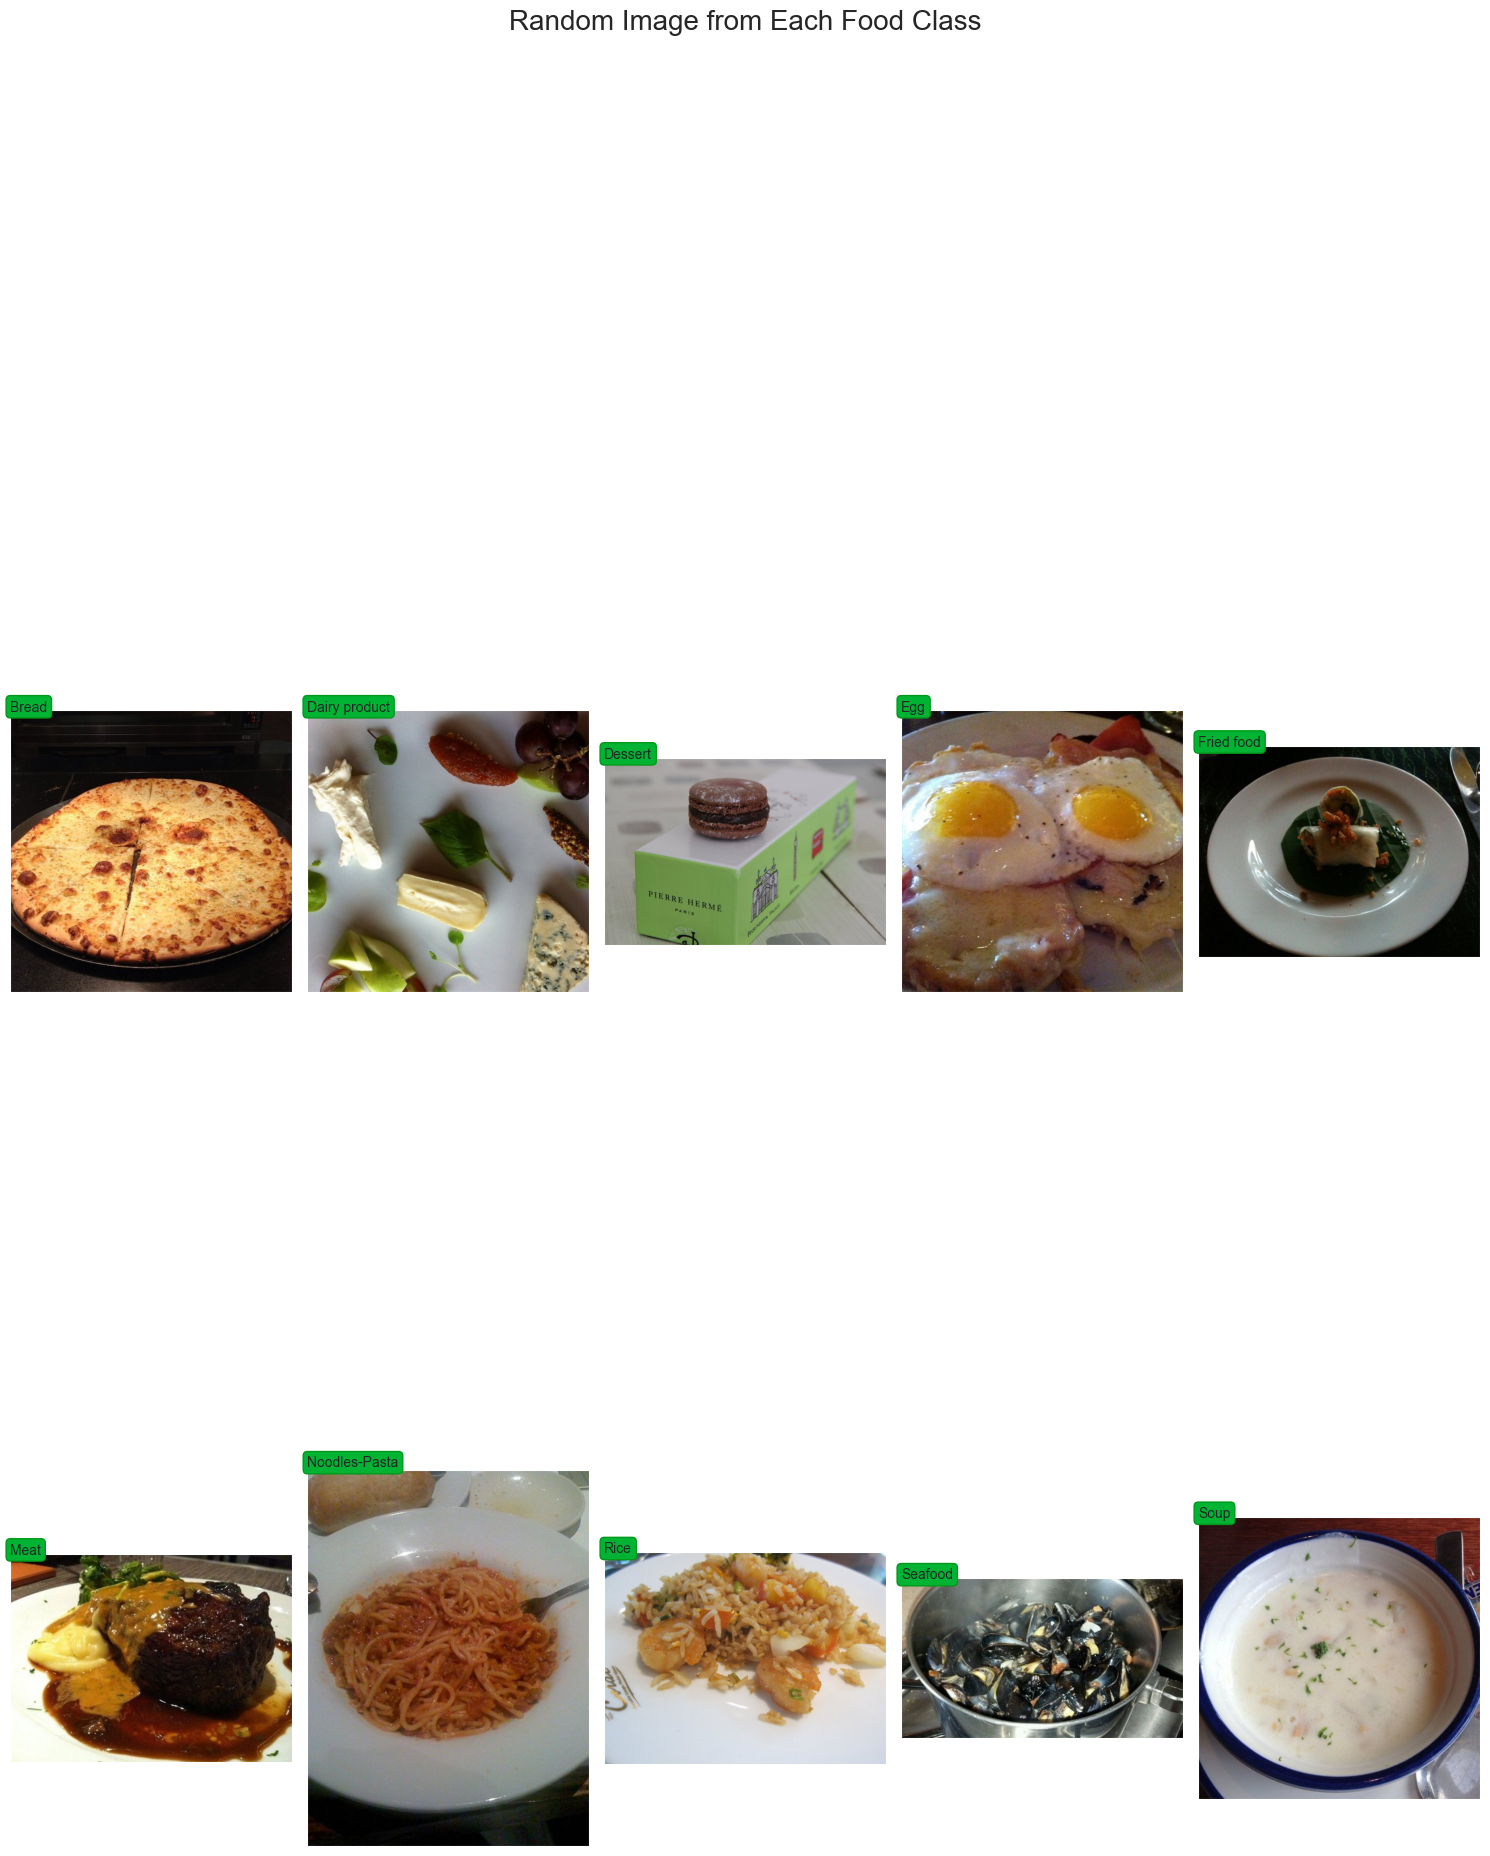

In [4]:
root_dir = os.getcwd() + "/Food11/training/"
rows = 2
cols = 5
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle("Random Image from Each Food Class", fontsize=20)

sorted_food_dirs = sorted(os.listdir(root_dir))

for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i * cols + j]
        except:
            break
        full_path = os.path.join(root_dir, food_dir)
        if os.path.isdir(full_path):
            all_files = os.listdir(full_path)
            rand_img = np.random.choice(all_files)
            img = plt.imread(os.path.join(full_path, rand_img))
            ax[i, j].imshow(img)
            ec = [0, .6, .1]
            fc = (0, 0.7, .2)
            ax[i, j].text(0, -20, food_dir, size=10, rotation=0,
                          ha="left", va="top",
                          bbox=dict(boxstyle="round", ec=ec, fc=fc))
        else:
            print(f"Not a directory: {full_path}")

plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [5]:
#Path Folder
current_path = os.getcwd()
log_file_path = current_path+'\logfile.txt'
logging.basicConfig(filename=log_file_path, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

logging.info('Code Start.')

data_dir_training = current_path+"/Food11/training/"
data_dir_training = pathlib.Path(data_dir_training).with_suffix('')

data_dir_validation = current_path+"/Food11/validation/"
data_dir_validation = pathlib.Path(data_dir_validation).with_suffix('')

data_dir_evaluation = current_path+"/Food11/evaluation/"
data_dir_evaluation = pathlib.Path(data_dir_evaluation).with_suffix('')

model_path = current_path+"/model"
history_path = current_path+'/model/trainingHistory.json'

In [6]:
class_names = np.array(sorted([item.name for item in data_dir_training.glob('*')])) 
num_of_classes = len(class_names)
print(class_names, num_of_classes)

['Bread' 'Dairy product' 'Dessert' 'Egg' 'Fried food' 'Meat'
 'Noodles-Pasta' 'Rice' 'Seafood' 'Soup' 'Vegetable-Fruit'] 11


In [7]:
tf.random.set_seed(42)
generator = ImageDataGenerator(rescale = 1./255.,
                              validation_split=0.2,
                              horizontal_flip=True,
                              vertical_flip=False,
                              zoom_range=0.05,
                              rotation_range=25)

In [8]:
train_data = generator.flow_from_directory(data_dir_training,
                                               batch_size=32, 
                                               target_size=(224, 224), 
                                               subset = "training",
                                               class_mode="categorical", 
                                               seed=42)

test_data = generator.flow_from_directory(data_dir_validation,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               subset = "validation",
                                               class_mode="categorical",
                                               seed=42)


eval_data = generator.flow_from_directory(data_dir_evaluation,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               subset = "validation",
                                               class_mode="categorical",
                                               seed=42)


Found 7896 images belonging to 11 classes.
Found 682 images belonging to 11 classes.
Found 666 images belonging to 11 classes.


In [9]:
def create_callbacks():
    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=10,
        verbose=1
    )
    callbacks = [earlystop]
    return callbacks

# Experiment

## 1. Create CNN Model

In [10]:
# Define the convolutional layers
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')
conv5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')

# Define the max pooling layers
max_pool1 = tf.keras.layers.MaxPooling2D((2, 2))
max_pool2 = tf.keras.layers.MaxPooling2D((2, 2))
max_pool3 = tf.keras.layers.MaxPooling2D((2, 2))

# Define the fully connected layers
fc1 = tf.keras.layers.Dense(1024, activation='relu')

# Define the output layer
output = tf.keras.layers.Dense(11, activation='softmax')

# Create the model
model = tf.keras.Sequential([
    conv1,
    max_pool1,
    conv2,
    max_pool2,
    conv3,
    max_pool3,
    conv4,
    conv5,
    tf.keras.layers.Flatten(),
    fc1,
    output
])

In [11]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

In [12]:
callbacks = create_callbacks()

In [27]:
history = model.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),batch_size=32,
                        verbose=1,callbacks=callbacks)



Epoch 1/10
247/247 [==============================] - 436s 2s/step - loss: 2.2571 - accuracy: 0.1902 - val_loss: 2.1552 - val_accuracy: 0.1979
Epoch 2/10
247/247 [==============================] - 437s 2s/step - loss: 2.0586 - accuracy: 0.2668 - val_loss: 2.0734 - val_accuracy: 0.2859
Epoch 3/10
247/247 [==============================] - 428s 2s/step - loss: 1.9165 - accuracy: 0.3281 - val_loss: 1.8565 - val_accuracy: 0.3343
Epoch 4/10
247/247 [==============================] - 423s 2s/step - loss: 1.7820 - accuracy: 0.3764 - val_loss: 1.8107 - val_accuracy: 0.3944
Epoch 5/10
247/247 [==============================] - 421s 2s/step - loss: 1.6903 - accuracy: 0.4165 - val_loss: 1.7925 - val_accuracy: 0.3739
Epoch 6/10
247/247 [==============================] - 427s 2s/step - loss: 1.5927 - accuracy: 0.4478 - val_loss: 1.6264 - val_accuracy: 0.4238
Epoch 7/10
247/247 [==============================] - 427s 2s/step - loss: 1.5246 - accuracy: 0.4683 - val_loss: 1.6076 - val_accuracy: 0.4516

In [28]:
model.evaluate(test_data)
model.save(current_path + '/model.h5')

22/22 [==============================] - 11s 484ms/step - loss: 1.5157 - accuracy: 0.4721


C:\Users\newto\.conda\envs\cas\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<Axes: >

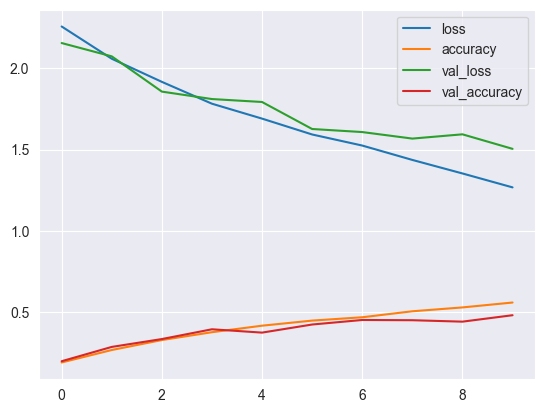

In [29]:
pd.DataFrame(history.history).plot()

In [30]:
y_pred = model.predict(test_data)

22/22 [==============================] - 11s 480ms/step


In [31]:
print("y pred before: ",y_pred[:5])
y_pred = y_pred.argmax(axis=1)
print("y pred after: ",y_pred[:5])

y pred before:  [[4.0720168e-01 1.2051939e-03 2.0599581e-02 5.6037050e-02 1.8365701e-01
  2.7869330e-03 2.1191820e-04 1.8086689e-02 2.6684264e-03 3.0749801e-01
  4.7484813e-05]
 [5.4166403e-02 2.7912632e-01 4.8209663e-02 4.9741793e-02 5.5232817e-01
  8.2796265e-04 8.6318715e-07 6.6951507e-05 1.4592216e-02 3.2249492e-04
  6.1720959e-04]
 [3.2751299e-02 1.7850924e-03 5.2920510e-03 7.3951714e-02 5.6554959e-04
  6.2982057e-05 1.3137992e-02 8.9589261e-02 6.1455816e-05 7.8279054e-01
  1.1993884e-05]
 [4.6372626e-04 1.1680757e-05 7.6893888e-02 2.6410900e-05 2.3244365e-04
  2.1439670e-01 4.7556628e-03 1.0909667e-02 3.6897451e-02 6.3820255e-01
  1.7209910e-02]
 [1.2312330e-01 3.6529011e-01 7.0039287e-02 2.2959644e-02 6.2340633e-03
  3.0517971e-04 3.1674191e-02 2.5561813e-01 9.0621517e-04 1.0435533e-01
  1.9494582e-02]]
y pred after:  [0 4 9 9 1]


## 2. EfficientNet Transfer Learning

In [9]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
feature_extractor_layer = hub.KerasLayer(efficientnet_url,
                                         trainable=True,
                                         name='feature_extraction_layer',
                                         input_shape=(224, 224, 3))

In [10]:
model_efficientNet = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_of_classes, activation='softmax', name='output_layer')
])

In [11]:
model_efficientNet.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [14]:
efficientnet_model = model_efficientNet.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),batch_size=32,
                        verbose=1,callbacks=callbacks)

Epoch 1/10
247/247 [==============================] - 979s 4s/step - loss: 0.9729 - accuracy: 0.7343 - val_loss: 0.8088 - val_accuracy: 0.8050
Epoch 2/10
247/247 [==============================] - 816s 3s/step - loss: 0.6256 - accuracy: 0.8441 - val_loss: 0.7587 - val_accuracy: 0.8079
Epoch 3/10
247/247 [==============================] - 781s 3s/step - loss: 0.5316 - accuracy: 0.8768 - val_loss: 0.8034 - val_accuracy: 0.8446
Epoch 4/10
247/247 [==============================] - 776s 3s/step - loss: 0.4862 - accuracy: 0.8905 - val_loss: 0.6573 - val_accuracy: 0.8534
Epoch 5/10
247/247 [==============================] - 774s 3s/step - loss: 0.4320 - accuracy: 0.9054 - val_loss: 0.8155 - val_accuracy: 0.7991
Epoch 6/10
247/247 [==============================] - 807s 3s/step - loss: 0.4215 - accuracy: 0.9129 - val_loss: 0.6165 - val_accuracy: 0.8622
Epoch 7/10
247/247 [==============================] - 831s 3s/step - loss: 0.3744 - accuracy: 0.9291 - val_loss: 0.7185 - val_accuracy: 0.8431

In [15]:
model_efficientNet.evaluate(eval_data)

21/21 [==============================] - 25s 1s/step - loss: 0.5592 - accuracy: 0.8844


[0.5591699481010437, 0.8843843936920166]

In [17]:
model_efficientNet.save(current_path + '/efficientNet.h5')
model_efficientNet.save(current_path + '/efficientNet.keras')

22/22 [==============================] - 21s 861ms/step
y pred before:  [[1.1293615e-02 4.7701865e-04 4.9642904e-04 8.3809614e-01 1.0762863e-01
  3.0670574e-02 2.3369445e-04 7.1249851e-03 4.3333208e-04 1.4036485e-04
  3.4052918e-03]
 [8.4558341e-12 3.1827382e-14 6.3356618e-09 6.0165449e-12 4.0532668e-14
  1.0127773e-09 5.1866084e-11 6.3701219e-17 1.6170236e-07 9.9999988e-01
  5.3142652e-15]
 [1.2439080e-01 2.0404367e-04 5.3113704e-03 3.2696140e-01 2.4643751e-02
  4.3422988e-01 2.6309455e-03 1.1223131e-03 3.1572208e-02 2.6262185e-02
  2.2671131e-02]
 [1.6193984e-05 5.5020890e-04 9.9563855e-01 5.0826033e-04 2.9951546e-04
  6.0439743e-05 5.4837724e-06 4.2844669e-05 3.1672572e-04 2.3300231e-03
  2.3183973e-04]
 [6.1965617e-03 1.9386566e-06 4.7993404e-04 1.0563630e-04 9.5706646e-06
  8.3676638e-04 1.0089893e-05 7.1129409e-07 2.2267418e-03 9.9012846e-01
  3.6697884e-06]]
y pred after:  [3 9 5 2 9]


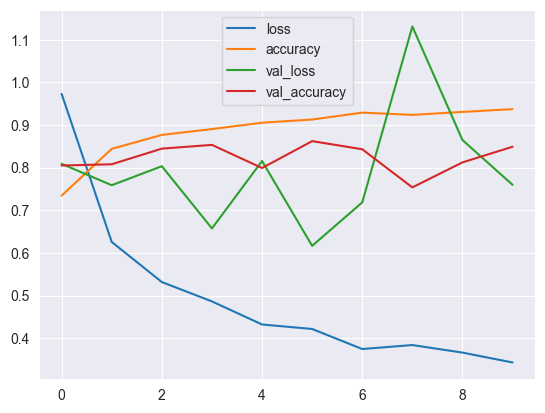

In [18]:
pd.DataFrame(efficientnet_model.history).plot()
y_pred_tl = model_efficientNet.predict(test_data)


print("y pred before: ",y_pred_tl[:5])
y_pred_tl = y_pred_tl.argmax(axis=1)
print("y pred after: ",y_pred_tl[:5])

## 3. ResNet Learning Model

In [13]:
ResNet_v2_50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'

model_ResNet = tf.keras.Sequential([
    hub.KerasLayer(ResNet_v2_50,trainable=True, input_shape=(250,250,3), name='Resnet_v2_50'),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_of_classes, activation='softmax', name='output_layer')
])

model_ResNet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [14]:
model_ResNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Resnet_v2_50 (KerasLayer)   (None, 1001)              25615849  
                                                                 
 dense (Dense)               (None, 256)               256512    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 output_layer (Dense)        (None, 11)                1419      
                                                                 
Total params: 25906676 (98.83 MB)
Trainable params: 25861236 (98.65 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


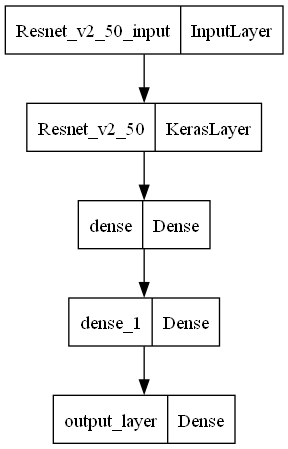

In [15]:
tf.keras.utils.plot_model(model_ResNet)

In [16]:
resnet_model = model_ResNet.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),batch_size=32,
                        verbose=1,callbacks=callbacks)

Epoch 1/10
247/247 [==============================] - 477s 2s/step - loss: 2.1887 - accuracy: 0.4005 - val_loss: 3.1145 - val_accuracy: 0.2933
Epoch 2/10
247/247 [==============================] - 459s 2s/step - loss: 1.7488 - accuracy: 0.5466 - val_loss: 2.5161 - val_accuracy: 0.3578
Epoch 3/10
247/247 [==============================] - 460s 2s/step - loss: 1.5618 - accuracy: 0.6109 - val_loss: 2.7290 - val_accuracy: 0.3959
Epoch 4/10
247/247 [==============================] - 461s 2s/step - loss: 1.4362 - accuracy: 0.6515 - val_loss: 1.9779 - val_accuracy: 0.5528
Epoch 5/10
247/247 [==============================] - 462s 2s/step - loss: 1.3473 - accuracy: 0.6902 - val_loss: 1.9324 - val_accuracy: 0.5425
Epoch 6/10
247/247 [==============================] - 460s 2s/step - loss: 1.3268 - accuracy: 0.6931 - val_loss: 1.8278 - val_accuracy: 0.5968
Epoch 7/10
247/247 [==============================] - 459s 2s/step - loss: 1.2519 - accuracy: 0.7188 - val_loss: 1.8444 - val_accuracy: 0.5601

In [17]:
model_ResNet.evaluate(eval_data)
model_ResNet.save(current_path + '/ResNet.h5')
model_ResNet.save(current_path + '/ResNet.keras')

21/21 [==============================] - 12s 575ms/step - loss: 1.5264 - accuracy: 0.6877


C:\Users\SuregonsLab\anaconda3\envs\cas\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 13s 560ms/step
y pred before:  [[1.6045383e-01 1.9475855e-01 1.1840950e-01 2.6377478e-01 1.4945565e-01
  2.9811902e-02 5.9198919e-03 5.8554732e-03 3.7770662e-02 6.6693085e-03
  2.7120426e-02]
 [1.2842744e-09 3.1161071e-13 7.1803972e-09 9.8694158e-14 1.4870696e-10
  1.8685949e-08 8.2196838e-10 1.4445778e-11 1.2407839e-09 1.0000000e+00
  1.8770634e-09]
 [5.3999280e-03 1.5070324e-03 3.4972128e-02 2.8397064e-03 1.9284897e-02
  5.9778567e-02 3.1967743e-03 1.4756452e-03 3.5923969e-02 7.8529841e-01
  5.0323017e-02]
 [3.5944441e-03 2.0359930e-01 3.8443843e-01 4.1881418e-03 1.9782195e-03
  4.0789829e-03 6.5174645e-05 1.2737591e-03 6.6632181e-03 3.8005853e-01
  1.0061818e-02]
 [1.9214138e-02 2.1236083e-03 6.5483816e-02 3.0362103e-02 1.3895919e-02
  4.8408642e-01 2.6053174e-03 2.8779728e-03 1.5336117e-01 1.5440568e-01
  7.1583733e-02]]
y pred after:  [3 9 9 2 5]


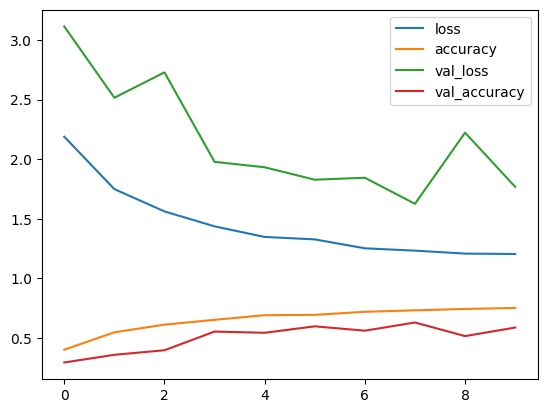

In [18]:
pd.DataFrame(resnet_model.history).plot()
y_pred_tl = model_ResNet.predict(test_data)


print("y pred before: ",y_pred_tl[:5])
y_pred_tl = y_pred_tl.argmax(axis=1)
print("y pred after: ",y_pred_tl[:5])

## 4. Inception V3 MODEL

In [24]:
inceptionv3_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

# Create a Keras layer using the URL
feature_extractor_layer_inc = hub.KerasLayer(
    inceptionv3_url,
    trainable=True,
    name='feature_extraction_layer',
    input_shape=(224, 224, 3)  # Correct input shape
)

# Build a simple model using the feature extractor layer
model_inceptionv3 = tf.keras.Sequential([
    feature_extractor_layer_inc,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(num_of_classes, activation='softmax', name='output_layer')
])

# Compile the model
model_inceptionv3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

inception_model = model_inceptionv3.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),batch_size=32,
                        verbose=1,callbacks=callbacks)

# Display the model summary
model_inceptionv3.summary()

Epoch 1/10
247/247 [==============================] - 314s 1s/step - loss: 1.6800 - accuracy: 0.5474 - val_loss: 2.5099 - val_accuracy: 0.4399
Epoch 2/10
247/247 [==============================] - 290s 1s/step - loss: 1.2480 - accuracy: 0.6859 - val_loss: 3.3065 - val_accuracy: 0.4106
Epoch 3/10
247/247 [==============================] - 290s 1s/step - loss: 1.0889 - accuracy: 0.7324 - val_loss: 2.5490 - val_accuracy: 0.4032
Epoch 4/10
247/247 [==============================] - 289s 1s/step - loss: 1.0169 - accuracy: 0.7575 - val_loss: 1.7231 - val_accuracy: 0.6173
Epoch 5/10
247/247 [==============================] - 289s 1s/step - loss: 0.9367 - accuracy: 0.7870 - val_loss: 1.8539 - val_accuracy: 0.6100
Epoch 6/10
247/247 [==============================] - 289s 1s/step - loss: 0.8738 - accuracy: 0.8052 - val_loss: 1.8226 - val_accuracy: 0.5689
Epoch 7/10
247/247 [==============================] - 289s 1s/step - loss: 0.8324 - accuracy: 0.8208 - val_loss: 1.5426 - val_accuracy: 0.6261

In [25]:
model_inceptionv3.evaluate(eval_data)
model_inceptionv3.save(current_path + '/inceptionv3.h5')
model_inceptionv3.save(current_path + '/inceptionv3.keras')

21/21 [==============================] - 10s 461ms/step - loss: 1.6224 - accuracy: 0.6562


C:\Users\SuregonsLab\anaconda3\envs\cas\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 10s 446ms/step
y pred before:  [[6.1772637e-02 5.9975530e-03 1.8827757e-02 2.7809937e-02 1.1330072e-02
  8.1336787e-03 2.3367964e-03 5.5557289e-03 1.5128539e-02 1.1285883e-02
  8.3182144e-01]
 [1.6920902e-02 1.0751621e-04 4.7175963e-03 3.2605740e-04 5.9822615e-04
  1.1137044e-02 2.8393147e-06 4.0872560e-06 9.6497124e-01 7.8270707e-04
  4.3188417e-04]
 [9.9992943e-01 1.7398026e-08 3.2034679e-06 4.6960686e-05 1.2925189e-05
  2.2418326e-06 1.7000796e-09 1.1953897e-08 4.5116162e-06 7.2037943e-07
  2.0333568e-08]
 [7.9649344e-02 8.0396146e-02 7.1409529e-01 3.1957850e-02 1.6720678e-03
  4.2398395e-03 3.8414559e-04 3.1598474e-04 9.9039720e-03 7.7150606e-02
  2.3477113e-04]
 [9.8884565e-01 3.4570181e-05 6.3606557e-03 1.5354052e-03 8.4611587e-05
  1.4284585e-04 2.2632760e-06 8.5060074e-06 1.8810682e-04 2.7960171e-03
  1.2674828e-06]]
y pred after:  [10  8  0  2  0]


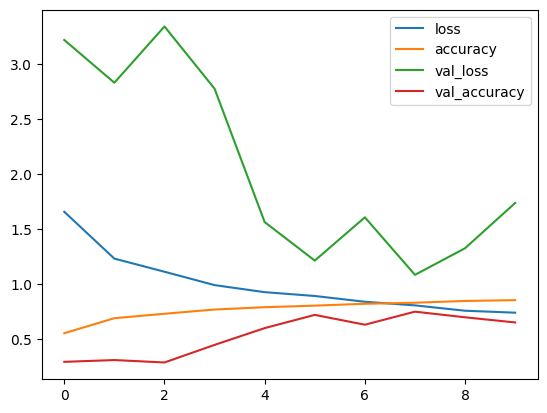

In [24]:
pd.DataFrame(inception_model.history).plot()
y_pred_tl = model_inceptionv3.predict(eval_data)


print("y pred before: ",y_pred_tl[:5])
y_pred_tl = y_pred_tl.argmax(axis=1)
print("y pred after: ",y_pred_tl[:5])

## 5. VGG16 NET

In [25]:
# Create a VGG16 base model (excluding the top dense layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = True

# Create a new model on top of the VGG16 base model
model_vgg16 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')  # Change the number of units based on your classification task
])

# Compile the model
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_vgg16.summary()

history_model_vgg16 = model_vgg16.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    batch_size=32,
)

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 4096)              102764544 
                                                                 
 dense_5 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_6 (Dense)             (None, 11)                45067     
                                                                 
Total params: 134305611 (512.34 MB)
Trainable params: 134305611 (512.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________

In [26]:
model_vgg16.save(current_path + '/model_vgg16.h5')

C:\Users\SuregonsLab\anaconda3\envs\cas\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model Comparisons

In [23]:
# Load all models
NormNet_model = load_model(current_path + '/model.h5')
EfficientNet_model = load_model(current_path + '/efficientNet.h5', custom_objects={'KerasLayer': hub.KerasLayer})
InceptionNet_model = load_model(current_path + '/inceptionv3.keras', custom_objects={'KerasLayer': hub.KerasLayer})
VGG16Net_model = load_model(current_path + '/model_vgg16.h5', custom_objects={'KerasLayer': hub.KerasLayer})
ResNet_v2_50_model = load_model(current_path + '/ResNet.keras', custom_objects={'KerasLayer': hub.KerasLayer})

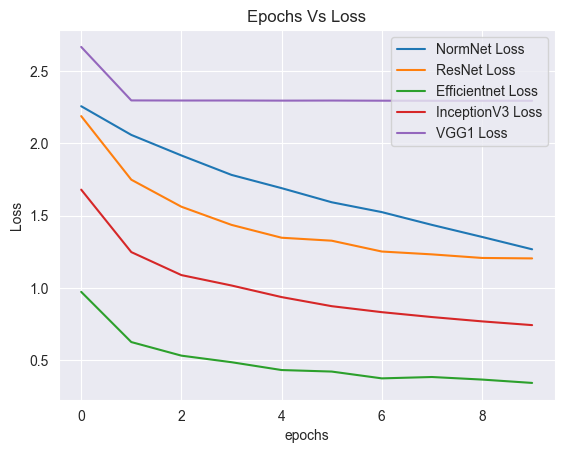

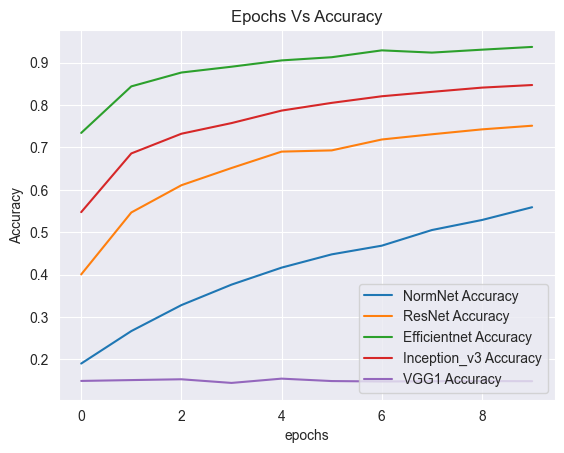

In [36]:
def plot_graph(history, history_1, history_2, history_4, history_3):
    loss_norm = history_2.history['loss']
    loss_res = history.history['loss']
    loss_ef = history_1.history['loss']
    loss_inc = history_4.history['loss']
    loss_vgg = history_3.history['loss']

    min_length = min(len(loss_norm), len(loss_res), len(loss_ef), len(loss_inc))

    accuracy_res = history.history['accuracy'][:min_length]
    accuracy_ef = history_1.history['accuracy'][:min_length]
    accuracy_norm = history_2.history['accuracy'][:min_length]
    accuracy_inc = history_4.history['accuracy'][:min_length]
    accuracy_vgg = history_3.history['accuracy'][:min_length]

    epochs = range(min_length)

    plt.plot(epochs, loss_norm[:min_length], label='NormNet Loss')
    plt.plot(epochs, loss_res[:min_length], label='ResNet Loss')
    plt.plot(epochs, loss_ef[:min_length], label='Efficientnet Loss')
    plt.plot(epochs, loss_inc[:min_length], label='InceptionV3 Loss')
    plt.plot(epochs, loss_vgg[:min_length], label='VGG1 Loss')
    plt.title('Epochs Vs Loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy_norm, label='NormNet Accuracy')
    plt.plot(epochs, accuracy_res, label='ResNet Accuracy')
    plt.plot(epochs, accuracy_ef, label='Efficientnet Accuracy')
    plt.plot(epochs, accuracy_inc, label='Inception_v3 Accuracy')
    plt.plot(epochs, accuracy_vgg, label='VGG1 Accuracy')
    plt.title('Epochs Vs Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()



plot_graph(resnet_model, efficientnet_model, history,inception_model,history_model_vgg16)